In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.Collecting xgboost
  Using cached xgboost-3.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 2.6/72.0 MB 23.4 MB/s eta 0:00:03
   ----- ---------------------------------- 9.2/72.0 MB 27.8 MB/s eta 0:00:03
   ---------- ----------------------------- 19.4/72.0 MB 36.3 MB/s eta 0:00:02
   ---------------- ----------------------- 29.1/72.0 MB 39.4 MB/s eta 0:00:02
   -------------------- ------------------- 37.7/72.0 MB 40.5 MB/s eta 0:00:01
   ------------------------- -------------- 45.6/72.0 MB 40.0 MB/s eta 0:00:01
   ------------------------------ --------- 55.6/72.0 MB 40.9 MB/s eta 0:00:01
   ------------------------------------ --- 65.3/72.0 MB 41.7 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 40.7 MB/s  0:00:01




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from pygam import LinearGAM, s, l
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

Leitura do dataset e visualização das linhas iniciais.

In [13]:
df = pd.read_csv('flight.csv')
df

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


A primeira coluna não é útil

In [17]:
df = df.drop('Unnamed: 0',axis=1)
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


AQui utilizamos o método describe para ver as estatisticas das variaveis numericas do dataset

In [18]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


Através desse método percebemos que em média os beneficiários principais tem um IMC bem alto estando na faixa de obesidade grau 1, com desvio padrão elevado, o que indica um grande espalhamento dos dados dessa coluna.

Além disso percebemos que ao menos 25% dos beneficiarios nao tem filhos e ao menos 50% tem 1 ou menos, alem disso esses dados sao extremamente espalhados tendo o desvio padrao maior que a média que é perto de 1

Ja para o preço percebemos que é bem pareciudo também tendo desvio padrao próximo da média e muito espalhamento tendo o seu minimo bem distante do maximo

Por fim, a idade dos beneficiarios varia de 18 a 64 anos, tendo em media 39 anos.

Agora analisemos se há algum dado corrompido ou nao computado nas colunas


In [19]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

Pecebemos que o dataset esta organizado e limpo

Vamos entao começar a tentar achar grupos de beneficiarios, faremos isso através do método k-means.

Primeiramente definiremos quais colunas sao numericas e quais sao categoricas

In [59]:
categorical_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
numerical_features = ['duration', 'days_left']

Após isso, aplicaremos transformações às colunas com objetivo de normalizar os dados, isso é necessário pois o k-means calcula distancias e ter alguma variavel numericamente muito maior que as outras ou muito menor pode causar problemas.

In [80]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough' 
)

X_prepared = preprocessor.fit_transform(df)

ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

Agora calcularemos a inercia para o k-means utilizando k de 1 até 11, isso serve para escolhermos qual seria o melhor k para usar, a inercia aqui significa a soma das distâncias quadráticas das amostras ao centro do cluster mais próximo.

In [78]:
inertia = []
K_range = range(1, 11) # Testaremos K de 1 a 10

In [79]:
for k in K_range:
    # n_init='auto' é o padrão moderno para evitar warnings futuros
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_model.fit(X_prepared)
    inertia.append(kmeans_model.inertia_)

ValueError: could not convert string to float: 'SG-8709'

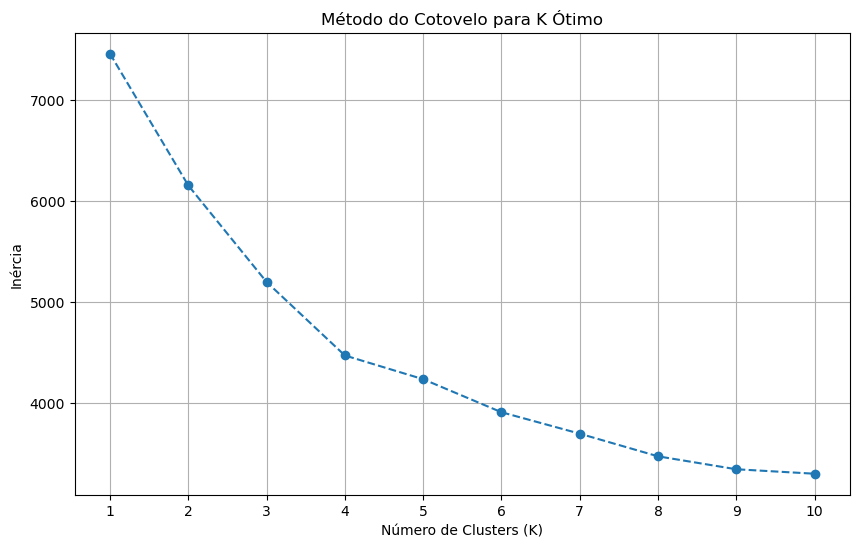

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para K Ótimo')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Uma possibilidade para escolher o k ideal é analisar o "cotovelo" do gráfico, isso é, onde a inercia ainda decresce bastanet e após esse valor para de diminuir tanto, nesse caso podemos observar que é o k = 4. Isso é um método interessante e 4 é um bom candidato, no entanto vamos utilizar outro método para reforçar a escolha de k

Usaremos a métrica Silhouette Score (Pontuação da Silhueta) que é a mais usada e famosa para essa escolha

A Silhouette Score nada mais é que um valor que mede o quão semelhante um ponto é do seu próprio cluster em comparação com outros clusters.

A fórmula para um único ponto é s=(b−a)​/max(a,b)

Onde a é a distância média desse ponto para todos os outros pontos no mesmo cluster (medida de coesão).

e b é a distância média desse ponto para todos os pontos no cluster vizinho mais próximo (medida de separação).

Nesse caso faremos o calculo até 11 klusters, o motivo disso é que não é vantajoso ter muitos clusters por mais que tenhamos métricas boas, isso ocorre porque os clusters serão extremamente especificos enão explicarão muito.

In [11]:
silhouette_scores = []

# O range começa em 2, pois o Silhouette Score não pode ser calculado para K=1
K_range_silhouette = range(2, 11)

for k in K_range_silhouette:
    # Rodar o K-Means para o valor de k atual
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans_model.fit_predict(X_prepared)
    
    # Calcular a média do Silhouette Score para todos os pontos
    score = silhouette_score(X_prepared, cluster_labels)
    silhouette_scores.append(score)
    print(f"Para K={k}, o Silhouette Score médio é: {score:.4f}")


Para K=2, o Silhouette Score médio é: 0.1702
Para K=3, o Silhouette Score médio é: 0.1777
Para K=4, o Silhouette Score médio é: 0.1982
Para K=5, o Silhouette Score médio é: 0.1661
Para K=6, o Silhouette Score médio é: 0.1647
Para K=7, o Silhouette Score médio é: 0.1556
Para K=8, o Silhouette Score médio é: 0.1550
Para K=9, o Silhouette Score médio é: 0.1551
Para K=10, o Silhouette Score médio é: 0.1529


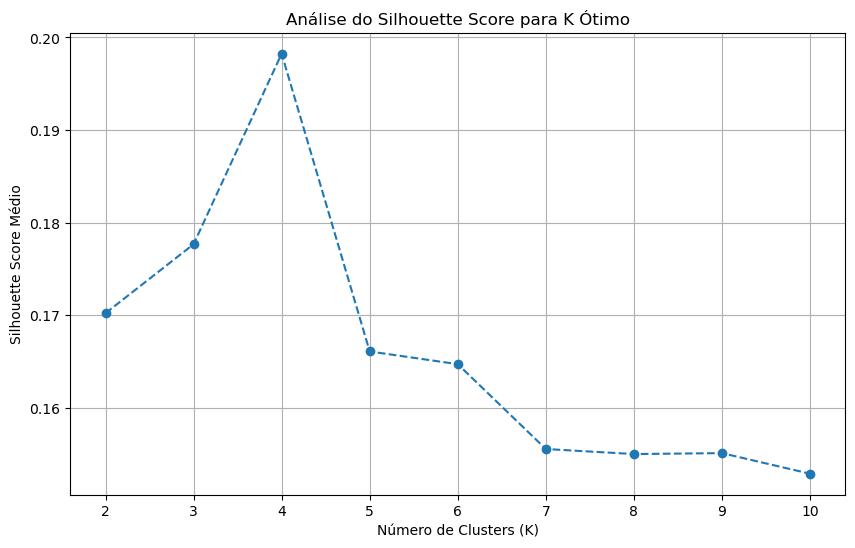

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(K_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score Médio')
plt.title('Análise do Silhouette Score para K Ótimo')
plt.xticks(K_range_silhouette)
plt.grid(True)
plt.show()

Após exibir o gráfico podemos notar que de fato o valor ótimo novamente foi 4, portanto nosso k-means final será com 4 clusters

In [13]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_prepared)

In [14]:
df['cluster'] = clusters


print(f"\n### Análise dos {optimal_k} Clusters Encontrados (Médias das Variáveis Numéricas) ###\n")
cluster_analysis_numeric = df.groupby('cluster')[numerical_features].mean().round(2)
print(cluster_analysis_numeric)

for feature in categorical_features:
    print(f"\n--- Distribuição de '{feature}' por Cluster ---")
    print(pd.crosstab(df['cluster'], df[feature]))


### Análise dos 4 Clusters Encontrados (Médias das Variáveis Numéricas) ###

           age    bmi  children   charges
cluster                                  
0        25.49  29.16      0.42   5488.01
1        39.91  30.00      2.68  10829.38
2        52.66  31.05      0.44  12842.09
3        39.47  35.20      1.13  40980.88

--- Distribuição de 'sex' por Cluster ---
sex      female  male
cluster              
0           217   207
1           175   172
2           214   197
3            56   100

--- Distribuição de 'smoker' por Cluster ---
smoker    no  yes
cluster          
0        380   44
1        307   40
2        373   38
3          4  152

--- Distribuição de 'region' por Cluster ---
region   northeast  northwest  southeast  southwest
cluster                                            
0               99        107        122         96
1               83         96         81         87
2              109         96        100        106
3               33         26      

Os clusters encontrados são extremaemente explicativos e segmentaram muito bem os beneficiários.


#### Cluster 0: Jovens Saudáveis de Baixo Custo Médio
Esse é o grupo de menor risco para a empresa e consequentemente tem o custo bastante reduzido, sendo em média 5000, o menor dos 4.
O perfil das pessoas desse grupo é uma idade relativamente baixa, sendo em média 25.5 anos, a mais baixa dos 4, predominantemente não fumantes e com poucos filhos, sendo em média 0.42, e o menor IMC médio, por mais que seja por pouco. Em resumo, o perfil é de jovens sem habito de tabagismo com poucos filhos e por isso tem custo menor.

#### Cluster 1: Famílias de Custo Moderado
Esse grupo é um que tem custo moderado, sendo o segundo menor mas consideravelmente maior que o cluster 0. Esse tem idade média de 39.6 anos e a maior média de filhos sendo de 2.68. São majoritariamente não fumantes e tem um IMC já na faixa de sobrepeso. Podemos entender esse grupo como de famílias, devido ao maior número de filhos e que portanto exigem mais do seguro de saúde

#### Cluster 2: Jovens Saudáveis de Baixo Custo Médio


#### Cluster 3: Jovens Saudáveis de Baixo Custo Médio


In [15]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# O método fit_predict retorna:
#  1 para observações "inliers" (normais)
# -1 para observações "outliers" (anômalas)
outlier_preds = iso_forest.fit_predict(X_prepared)

In [16]:
df['is_outlier'] = outlier_preds

# --- 3. ANÁLISE DOS OUTLIERS ENCONTRADOS ---
print("### Análise dos Outliers com Isolation Forest ###")
print(f"Total de outliers encontrados: {np.sum(df['is_outlier'] == -1)}")

# Filtrar e exibir os outliers
outliers = df[df['is_outlier'] == -1]

print("\n--- Características dos Outliers (Estatísticas Descritivas) ---")
print(outliers[numerical_features].describe())

print("\n--- Características dos Inliers (para comparação) ---")
inliers = df[df['is_outlier'] == 1]
print(inliers[numerical_features].describe())

print("\n--- Amostra de Outliers Encontrados ---")
# Mostrando algumas colunas chave para facilitar a interpretação
print(outliers[['age', 'bmi', 'smoker', 'charges']].head(15))

### Análise dos Outliers com Isolation Forest ###
Total de outliers encontrados: 67

--- Características dos Outliers (Estatísticas Descritivas) ---
             age        bmi   children       charges
count  67.000000  67.000000  67.000000     67.000000
mean   42.701493  32.371269   1.716418  37683.347421
std    15.992437   7.464595   1.368542  12269.543031
min    18.000000  17.290000   0.000000  12829.455100
25%    30.000000  27.700000   0.000000  29099.823525
50%    44.000000  32.800000   2.000000  40904.199500
75%    58.500000  36.955000   3.000000  46458.277450
max    64.000000  47.600000   5.000000  63770.428010

--- Características dos Inliers (para comparação) ---
               age          bmi     children       charges
count  1271.000000  1271.000000  1271.000000   1271.000000
mean     39.022817    30.573367     1.062156  11983.509609
std      13.922857     6.007668     1.187895  10652.053136
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26

In [17]:
df_apriori = df.copy()
df_apriori['age_cat'] = pd.cut(df['age'],
                               bins=[0, 29, 49, 100],
                               labels=['Jovem', 'MeiaIdade', 'Idoso'])

df_apriori['bmi_cat'] = pd.cut(df['bmi'],
                               bins=[0, 18.5, 24.9, 29.9, 100],
                               labels=['AbaixoDoPeso', 'Normal', 'Sobrepeso', 'Obeso'])

df_apriori['charges_cat'] = pd.qcut(df['charges'],
                                    q=4,
                                    labels=['Custo_Baixo', 'Custo_Medio', 'Custo_Alto', 'Custo_MuitoAlto'])

df_rules = df_apriori[['sex', 'smoker', 'region', 'age_cat', 'bmi_cat', 'charges_cat']]

In [18]:
transactions = []
for i in range(len(df_rules)):
    transactions.append([str(df_rules.values[i, j]) for j in range(len(df_rules.columns))])

In [19]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

In [20]:
frequent_itemsets = apriori(df_onehot, min_support=0.05, use_colnames=True)

# Gerar as regras de associação com base na métrica 'confidence'
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# --- 3. ANÁLISE DAS REGRAS ENCONTRADAS ---
print("\n### Análise de Regras de Associação com Apriori ###")

# Filtrar e ordenar as regras para ver as mais interessantes
# Lift > 1 indica que a ocorrência do 'consequente' é mais provável quando o 'antecedente' ocorre.
interesting_rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.8)].sort_values(by='lift', ascending=False)

print("Regras de Associação mais fortes encontradas:")
print(interesting_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


### Análise de Regras de Associação com Apriori ###
Regras de Associação mais fortes encontradas:
                            antecedents        consequents   support  \
249  (male, Custo_MuitoAlto, MeiaIdade)              (yes)  0.051570   
85         (Custo_MuitoAlto, MeiaIdade)              (yes)  0.088939   
82                         (yes, Idoso)  (Custo_MuitoAlto)  0.050822   
88                         (Obeso, yes)  (Custo_MuitoAlto)  0.109865   
252                  (male, Obeso, yes)  (Custo_MuitoAlto)  0.070254   
..                                  ...                ...       ...   
202     (Custo_Baixo, Jovem, northwest)               (no)  0.053064   
198          (Custo_Baixo, male, Jovem)               (no)  0.108371   
194        (Custo_Baixo, Jovem, female)               (no)  0.102392   
219     (Custo_Medio, Obeso, MeiaIdade)               (no)  0.114350   
41              (southeast, Custo_Alto)               (no)  0.050075   

     confidence      lift  
249    0

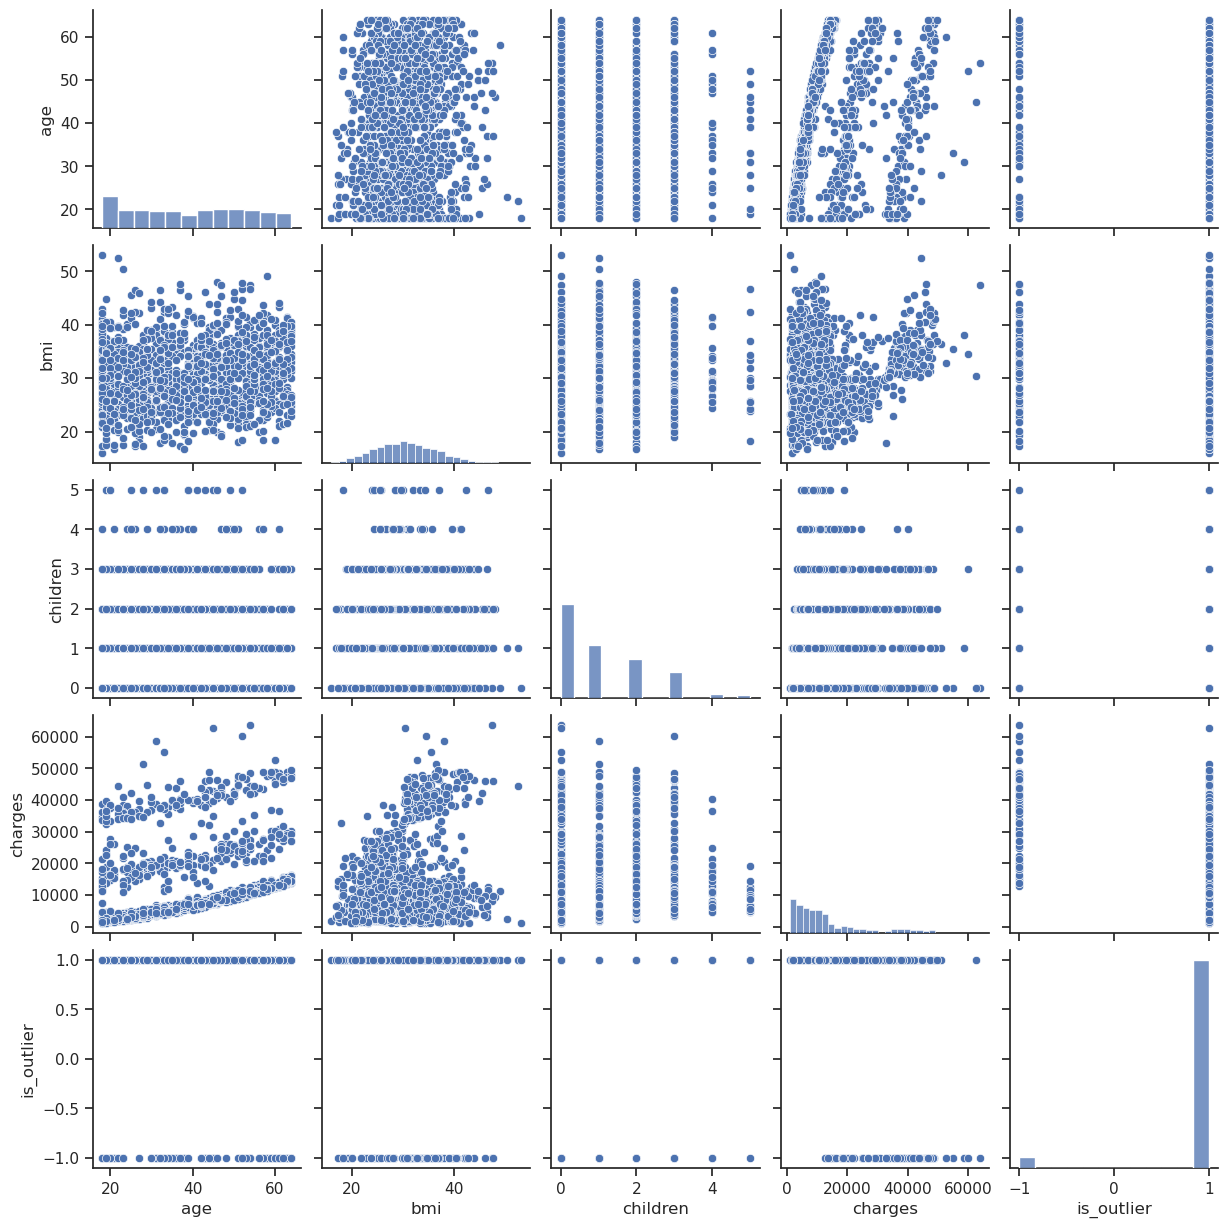

In [21]:
sns.set_theme(style="ticks")
df = df.drop(columns=['cluster'])
sns.pairplot(df)


In [20]:
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [72]:
df_encoded = pd.get_dummies(df, columns=['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class'], drop_first=True)

X = df_encoded.drop(['flight', 'price'], axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# REGRESSÃO LINEAR

In [73]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\n--- Resultados da Avaliação do Modelo ---")
r2 = metrics.r2_score(y_test, y_pred)
print(f"R-quadrado (R²): {r2:.4f}")


--- Resultados da Avaliação do Modelo ---
R-quadrado (R²): 0.9113


In [23]:
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f"Erro Absoluto Médio (MAE): {mae:,.2f}")

Erro Absoluto Médio (MAE): 4,553.29


In [24]:
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): 6,761.71


In [25]:
print("\n--- Coeficientes do Modelo ---")
coeficientes = pd.DataFrame(model.coef_, X.columns, columns=['Coeficiente'])
print(coeficientes)


--- Coeficientes do Modelo ---
                               Coeficiente
duration                         42.925692
days_left                      -130.444752
airline_Air_India               114.180024
airline_GO_FIRST               1692.092224
airline_Indigo                 2124.326815
airline_SpiceJet               2303.987022
airline_Vistara                4068.912347
source_city_Chennai             -75.340123
source_city_Delhi             -1412.890361
source_city_Hyderabad         -1675.434551
source_city_Kolkata            1596.247017
source_city_Mumbai             -208.140229
departure_time_Early_Morning    810.165610
departure_time_Evening          737.290649
departure_time_Late_Night      1540.670720
departure_time_Morning          866.529774
departure_time_Night            663.014360
stops_two_or_more              2105.242062
stops_zero                    -7613.334524
arrival_time_Early_Morning     -768.132641
arrival_time_Evening            923.699683
arrival_time_Late_Nigh

# RIDGE


In [70]:
model_ridge = linear_model.Ridge()
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print("\n--- Resultados da Avaliação do Modelo ---")
r2_ridge = metrics.r2_score(y_test, y_pred_ridge)
print(f"R-quadrado (R²): {r2_ridge:.4f}")


--- Resultados da Avaliação do Modelo ---
R-quadrado (R²): 0.9113


In [27]:
mae_ridge = metrics.mean_absolute_error(y_test, y_pred_ridge)
print(f"Erro Absoluto Médio (MAE): {mae_ridge:,.2f}")

Erro Absoluto Médio (MAE): 4,553.28


In [28]:
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_ridge:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): 6,761.71


In [29]:
print("\n--- Coeficientes do Modelo ---")
coef_ridge = pd.DataFrame(model_ridge.coef_, X.columns, columns=['Coeficiente'])
print(coef_ridge)


--- Coeficientes do Modelo ---
                               Coeficiente
duration                         42.938387
days_left                      -130.445144
airline_Air_India               113.652638
airline_GO_FIRST               1691.092566
airline_Indigo                 2123.331373
airline_SpiceJet               2302.638207
airline_Vistara                4068.445147
source_city_Chennai             -75.278571
source_city_Delhi             -1412.838066
source_city_Hyderabad         -1675.352570
source_city_Kolkata            1596.242603
source_city_Mumbai             -208.077359
departure_time_Early_Morning    809.993903
departure_time_Evening          737.107277
departure_time_Late_Night      1538.945366
departure_time_Morning          866.388855
departure_time_Night            662.807875
stops_two_or_more              2104.627262
stops_zero                    -7612.872202
arrival_time_Early_Morning     -768.140111
arrival_time_Evening            923.631433
arrival_time_Late_Nigh

# LASSO

In [30]:
model_lasso = linear_model.Lasso()
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
print("\n--- Resultados da Avaliação do Modelo ---")
r2_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(f"R-quadrado (R²): {r2_lasso:.4f}")


--- Resultados da Avaliação do Modelo ---
R-quadrado (R²): 0.9113


In [31]:
mae_lasso = metrics.mean_absolute_error(y_test, y_pred_lasso)
print(f"Erro Absoluto Médio (MAE): {mae_lasso:,.2f}")

Erro Absoluto Médio (MAE): 4,552.56


In [32]:
rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_lasso:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): 6,761.93


In [33]:
print("\n--- Coeficientes do Modelo ---")
coef_lasso = pd.DataFrame(model_lasso.coef_, X.columns, columns=['Coeficiente'])
print(coef_lasso)


--- Coeficientes do Modelo ---
                               Coeficiente
duration                         43.954504
days_left                      -130.479264
airline_Air_India                 0.000000
airline_GO_FIRST               1574.198397
airline_Indigo                 2011.476914
airline_SpiceJet               2158.758785
airline_Vistara                3960.111313
source_city_Chennai             -45.194212
source_city_Delhi             -1389.674605
source_city_Hyderabad         -1646.976516
source_city_Kolkata            1608.374844
source_city_Mumbai             -178.511211
departure_time_Early_Morning    768.849645
departure_time_Evening          698.333978
departure_time_Late_Night      1263.211404
departure_time_Morning          830.387243
departure_time_Night            614.773411
stops_two_or_more              2066.294824
stops_zero                    -7592.424036
arrival_time_Early_Morning     -766.436736
arrival_time_Evening            896.996432
arrival_time_Late_Nigh

In [63]:
model_lasso_cv = LassoCV(cv=10, random_state=42)
model_lasso_cv.fit(X_train, y_train)
y_pred_lasso_cv = model_lasso_cv.predict(X_test)
print("\n--- Resultados da Avaliação do Modelo ---")
r2_lasso_cv = metrics.r2_score(y_test, y_pred_lasso_cv)
print(f"R-quadrado (R²): {r2_lasso_cv:.4f}")


--- Resultados da Avaliação do Modelo ---
R-quadrado (R²): 0.9106


In [65]:
mae_lasso_cv = metrics.mean_absolute_error(y_test, y_pred_lasso_cv)
print(f"Erro Absoluto Médio (MAE): {mae_lasso_cv:,.2f}")

Erro Absoluto Médio (MAE): 4,522.07


In [66]:
rmse_lasso_cv = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso_cv))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_lasso_cv:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): 6,788.93


In [67]:
rmse_lasso_cv = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso_cv))
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_lasso_cv:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): 6,788.93


In [68]:
print("\n--- Coeficientes do Modelo ---")
coef_lasso_cv = pd.DataFrame(model_lasso_cv.coef_, X.columns, columns=['Coeficiente'])
print(coef_lasso_cv)


--- Coeficientes do Modelo ---
                               Coeficiente
duration                         56.349754
days_left                      -131.255245
airline_Air_India             -1171.416684
airline_GO_FIRST                  0.000000
airline_Indigo                  361.165727
airline_SpiceJet                  0.000000
airline_Vistara                2650.830107
source_city_Chennai               0.000000
source_city_Delhi             -1107.560285
source_city_Hyderabad         -1241.569617
source_city_Kolkata            1511.444547
source_city_Mumbai               -0.000000
departure_time_Early_Morning     31.754144
departure_time_Evening            0.000000
departure_time_Late_Night         0.000000
departure_time_Morning          184.320622
departure_time_Night             -0.000000
stops_two_or_more              1089.107594
stops_zero                    -7146.790706
arrival_time_Early_Morning     -524.040036
arrival_time_Evening            423.006184
arrival_time_Late_Nigh

In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicamos a mesma transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

In [35]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

y_pred_knn = knn_model.predict(X_test_scaled)


# --- Passo 6: Avaliar o Desempenho do Modelo ---
print("\n--- Resultados da Avaliação do Modelo KNN ---")

# R-quadrado (R²)
r2_knn = metrics.r2_score(y_test, y_pred_knn)
print(f"R-quadrado (R²): {r2_knn:.4f}")


--- Resultados da Avaliação do Modelo KNN ---
R-quadrado (R²): 0.9691


In [36]:
mae_knn = metrics.mean_absolute_error(y_test, y_pred_knn)
print(f"Erro Absoluto Médio (MAE): ${mae_knn:,.2f}")

Erro Absoluto Médio (MAE): $1,851.85


In [37]:
rmse_knn = np.sqrt(metrics.mean_squared_error(y_test, y_pred_knn))
print(f"Raiz do Erro Quadrático Médio (RMSE): ${rmse_knn:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): $3,992.48


# GAM 


In [ ]:
gam_model = LinearGAM(s(0) + s(1) + l(2) + l(3) + l(4) + l(5) + l(6) + l(7)).fit(X_train, y_train)

gam_model.summary()

y_pred_gam = gam_model.predict(X_test)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.9996
Link Function:                     IdentityLink Log Likelihood:                              -4974693.5497
Number of Samples:                       240122 AIC:                                          9949409.0986
                                                AICc:                                         9949409.0997
                                                GCV:                                        396622257.6518
                                                Scale:                                      396592527.3571
                                                Pseudo R-Squared:                                   0.2301
Feature Function                  Lam

C:\Users\igora\AppData\Local\Temp\ipykernel_19108\366792305.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_model.summary()


In [49]:
print("\n--- Resultados da Avaliação do Modelo GAM (Smoothing Splines) ---")

# R-quadrado (R²)
r2_gam = metrics.r2_score(y_test, y_pred_gam)
print(f"R-quadrado (R²): {r2_gam:.4f}")


--- Resultados da Avaliação do Modelo GAM (Smoothing Splines) ---
R-quadrado (R²): 0.2325


In [50]:
mae_gam = metrics.mean_absolute_error(y_test, y_pred_gam)
print(f"Erro Absoluto Médio (MAE): ${mae_gam:,.2f}")

Erro Absoluto Médio (MAE): $15,978.44


In [51]:
rmse_gam = np.sqrt(metrics.mean_squared_error(y_test, y_pred_gam))
print(f"Raiz do Erro Quadrático Médio (RMSE): ${rmse_gam:,.2f}")

Raiz do Erro Quadrático Médio (RMSE): $19,890.51


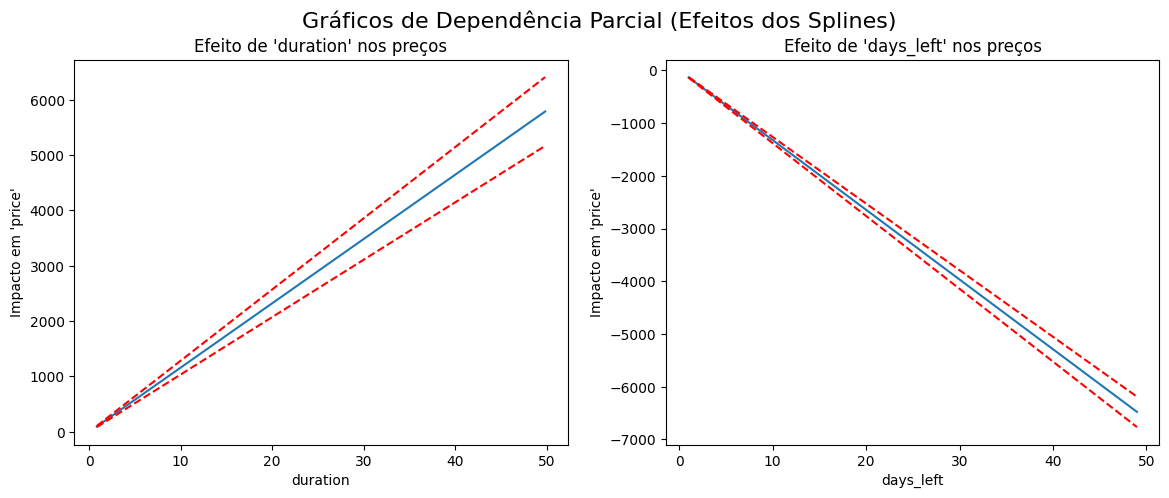

In [53]:
import matplotlib.pyplot as plt

# Cria a figura para os gráficos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico para a primeira variável (age)
titles = ['duration', 'days_left']
for i, ax in enumerate(axes):
    XX = gam_model.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_model.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(f"Efeito de '{titles[i]}' nos preços")
    ax.set_xlabel(titles[i])
    ax.set_ylabel("Impacto em 'price'")

plt.suptitle("Gráficos de Dependência Parcial (Efeitos dos Splines)", fontsize=16)
plt.show()

In [54]:
gam_model_scaled = LinearGAM(l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7) + s(8))
gam_model_scaled.fit(X_train_scaled, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=l(0) + l(1) + l(2) + l(3) + l(4) + l(5) + l(6) + s(7) + s(8) + intercept,
   tol=0.0001, verbose=False)

In [55]:
y_pred_gam_scaled = gam_model_scaled.predict(X_test_scaled)
r2_gam_scaled = metrics.r2_score(y_test, y_pred_gam_scaled)

print(f"\n--- Comparação de R² ---")
# r2_gam é o valor que você obteve com o ajuste automático
print(f"R-quadrado do GAM (automático): {r2_gam:.4f}") 
print(f"R-quadrado do GAM (otimizado): {r2_gam_scaled:.4f}")


--- Comparação de R² ---
R-quadrado do GAM (automático): 0.2325
R-quadrado do GAM (otimizado): 0.2325


# XGBOOST


In [56]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)

xgb_model.fit(X_train, y_train)

# --- Avaliação ---
y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = metrics.r2_score(y_test, y_pred_xgb)

print("--- RESULTADO COM XGBOOST ---")
print(f"R² do XGBoost: {r2_xgb:.4f}")

--- RESULTADO COM XGBOOST ---
R² do XGBoost: 0.9676


# RANDOM FOREST

In [57]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)

rf_model.fit(X_train, y_train)

# --- Avaliação ---
y_pred_rf = rf_model.predict(X_test)
r2_rf = metrics.r2_score(y_test, y_pred_rf)

print("--- RESULTADO COM RANDOM FOREST ---")
print(f"R² do Random Forest: {r2_rf:.4f}")

KeyboardInterrupt: 

# SVR

In [69]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()

svr_model = SVR(kernel='rbf', C=1000, gamma='auto')

svr_model.fit(X_train_scaled, y_train_scaled)

# --- Avaliação ---
# Prever com os dados escalados
y_pred_scaled = svr_model.predict(X_test_scaled)
# Reverter a previsão para a escala original de dólares
y_pred_svr = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

r2_svr = metrics.r2_score(y_test, y_pred_svr)

print("--- RESULTADO COM SVR ---")
print(f"R² do SVR: {r2_svr:.4f}")

--- RESULTADO COM SVR ---
R² do SVR: 0.7875


# REDES NEURAIS


In [71]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32), # Duas camadas ocultas: a primeira com 64 neurônios, a segunda com 32.
    activation='relu',           # Função de ativação padrão e mais eficiente.
    solver='adam',               # O otimizador mais popular e robusto.
    max_iter=1000,               # Número máximo de épocas (passagens pelos dados).
    alpha=0.01,                  # Parâmetro de regularização para evitar overfitting.
    early_stopping=True,         # Para o treino se a performance não melhorar, evitando overfitting.
    random_state=42
)

# Treinar o modelo com os dados padronizados
mlp_model.fit(X_train_scaled, y_train)

print("Treinamento concluído!")

# --- 4. Avaliação ---
# Fazer previsões com os dados de teste PADRONIZADOS
y_pred_mlp = mlp_model.predict(X_test_scaled)

# Calcular o R²
r2_mlp = metrics.r2_score(y_test, y_pred_mlp)

# Supondo que você salvou o r2 da regressão linear na variável r2_linear
print("\n--- RESULTADO COM MLP (Rede Neural) ---")
print(f"R² do MLP Regressor: {r2_mlp:.4f}")

Treinamento concluído!

--- RESULTADO COM MLP (Rede Neural) ---
R² do MLP Regressor: 0.8150
